c:\gym\gym_env\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\gym\gym_env\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/50, Total Reward: 169116.1771609519
Epoch 2/50, Total Reward: 216534.20283841048
Epoch 3/50, Total Reward: 217075.33374587903
Epoch 4/50, Total Reward: 216165.86329659176
Epoch 5/50, Total Reward: 216989.91198872388
Epoch 6/50, Total Reward: 216383.49327720774
Epoch 7/50, Total Reward: 217083.32712000574
Epoch 8/50, Total Reward: 216328.81062324
Epoch 9/50, Total Reward: 215783.91636606748
Epoch 10/50, Total Reward: 216959.99303739704
Epoch 11/50, Total Reward: 216399.2269792407
Epoch 12/50, Total Reward: 216478.14818017074
Epoch 13/50, Total Reward: 216507.3282209205
Epoch 14/50, Total Reward: 216384.5268681694
Epoch 15/50, Total Reward: 216501.15574450526
Epoch 16/50, Total Reward: 216294.3735766347
Epoch 17/50, Total Reward: 216684.10420832338
Epoch 18/50, Total Reward: 217666.24744136538
Epoch 19/50, Total Reward: 216423.70158635176
Epoch 20/50, Total Reward: 216458.28033397222
Epoch 21/50, Total Reward: 216712.2136013681
Epoch 22/50, Total Reward: 216400.9059493951
Epoch 2

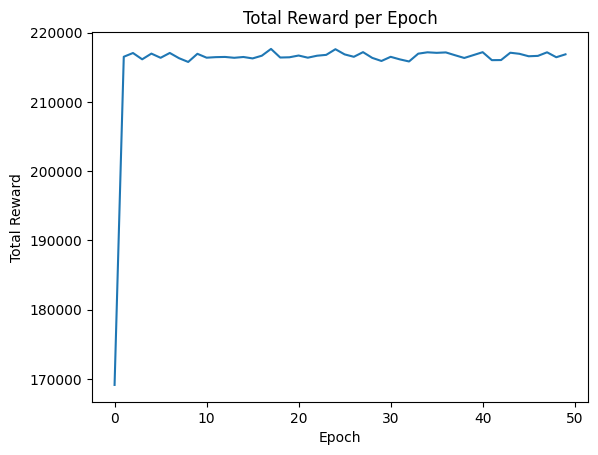

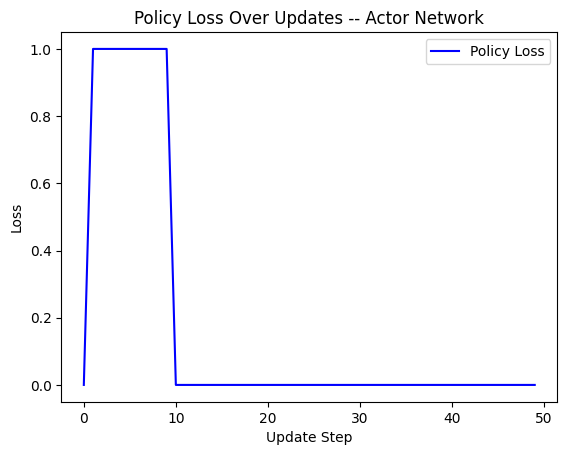

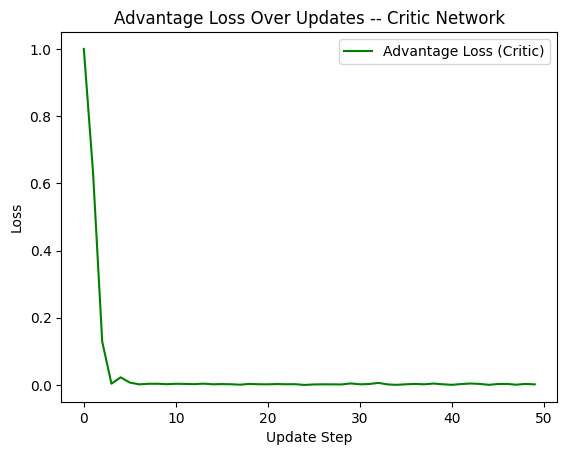

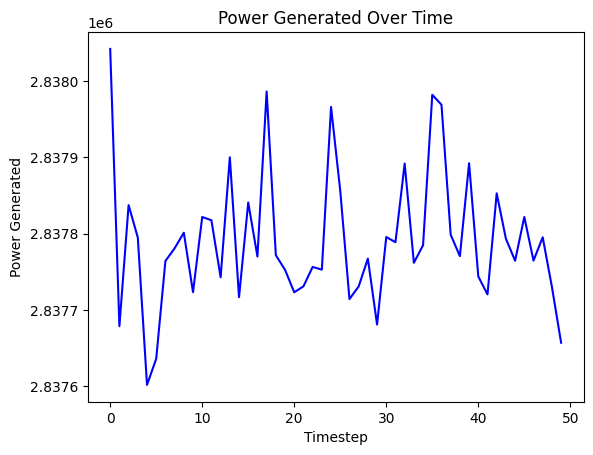

average return 215707.16546125076
Variance of reward 44475817.23540018


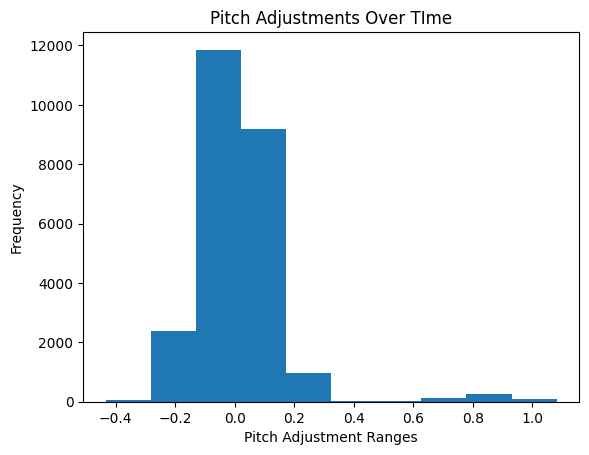

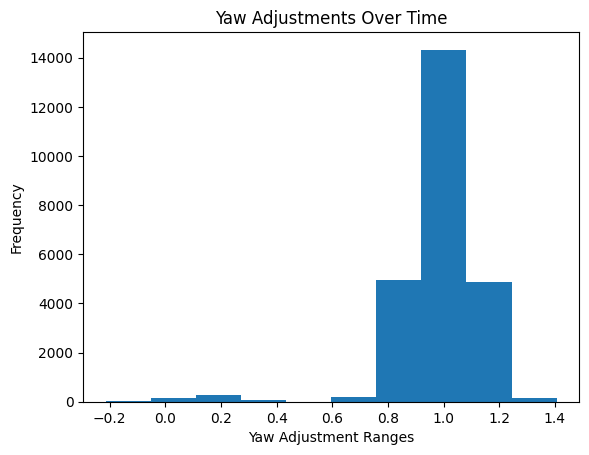


Final Policy Parameters (Actor Network):
0.weight: tensor([[ 2.2992e-01,  1.0450e-01, -2.4649e-01],
        [-4.6822e-01,  1.0399e-01, -1.3108e-01],
        [-3.0926e-01, -4.7478e-01, -2.8611e-02],
        [ 3.4536e-01,  1.3357e-01,  4.7306e-01],
        [ 3.1099e-01,  3.6284e-01,  1.9104e-01],
        [ 1.9476e-01, -3.8261e-01, -1.7588e-01],
        [ 7.9294e-02, -1.7756e-01,  3.6595e-01],
        [ 2.4392e-03, -1.1004e-01, -5.5251e-01],
        [ 4.1213e-01, -1.5595e-01, -2.6173e-01],
        [-4.3501e-01,  2.3506e-01,  2.3439e-02],
        [ 4.3485e-01, -3.2971e-01, -2.3460e-01],
        [ 1.6526e-03, -3.5683e-01,  5.0736e-01],
        [-4.6689e-02,  5.1628e-01, -2.9852e-01],
        [-2.7053e-02, -5.1166e-01,  4.6185e-01],
        [ 4.0309e-01, -1.2896e-01, -4.1295e-01],
        [-1.0343e-01, -8.3523e-03, -3.0593e-01],
        [ 1.5952e-01,  5.3973e-01, -2.7749e-02],
        [-1.9566e-01, -4.3006e-01, -1.3998e-01],
        [ 1.3168e-01,  1.9116e-01,  3.9905e-01],
        [ 2.3820e

In [30]:
import gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import time
import scipy.stats as stats


# Environment: Define or use a simplified wind turbine environment
class WindTurbineEnv(gym.Env):
    def __init__(self):
        super(WindTurbineEnv, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([3.0, 0.0, -10.0]),  # Wind speed, yaw, pitch (min values)
            high=np.array([25.0, 360.0, 10.0]),  # Wind speed, yaw, pitch (max values)
            dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=np.array([-10.0, -2.0]),  # Adjustments for yaw and pitch (min values)
            high=np.array([10.0, 2.0]),  # Adjustments for yaw and pitch (max values)
            dtype=np.float32
        )
        self.state = None

    def reset(self):
        self.state = np.array([10.0, 180.0, 0.0])  # Initial wind speed, yaw, pitch
        return self.state

    def step(self, action):
        wind_speed, yaw, pitch = self.state
        yaw += action[0]
        pitch += action[1]
        '''yaw =yaw%360
        if pitch>10:
            pitch = pitch%10-10'''
        #cliping the pitch and yaw within limits
        yaw=np.clip(yaw,0,360)
        pitch=np.clip(pitch,-10,10)

        # Calculate power coefficient (simplified example) and keeping it possitive
        cp = abs(math.cos(math.radians(pitch))*math.cos(math.radians(yaw)))
        power = cp * (wind_speed ** 3) * 0.5   # Simplified power production formula
        
        reward = power -(action[0]**2+action[1]**2)  #penalising for unnecessary movements

        self.state = np.array([wind_speed, yaw, pitch])
        done = False  # Continuous task; you can define terminal conditions if needed
        return self.state, reward, done, {}


# PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.999, epsilon=0.2, policy_update_steps=10):
        self.gamma = gamma
        self.epsilon = epsilon
        self.policy_update_steps = policy_update_steps

        # Actor-Critic networks
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim), nn.Softmax()
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.policy_losses = []
        self.critic_losses = []

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        mean = self.actor(state)
        dist = torch.distributions.Normal(mean, 0.1)  # Add a small standard deviation for exploration
        action = dist.sample()
        return action.detach().numpy(), dist.log_prob(action).sum().detach()

    def update(self, trajectories):
        states, actions, rewards, log_probs, dones = zip(*trajectories)
        returns=[0]*len(rewards)
        for i in range(len(rewards)-2,-1,-1):
            returns[i]+=returns[i+1]
            

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        log_probs = torch.tensor(log_probs, dtype=torch.float32)
        returns = torch.tensor(returns,dtype=torch.float32)
        

        # Compute advantages
        values = self.critic(states).squeeze().detach()
        #advantages = rewards - values.detach()
        advantages = torch.zeros_like(returns, dtype=torch.float32, device=returns.device)
        lambd=0.95
        advantage = 0.0  # Initialize scalar

        for t in reversed(range(len(rewards))):
            td_error = returns[t] - values[t]  # TD error: difference between return and value
            advantage = td_error + self.gamma * lambd * advantage
            advantages[t] = advantage
        
        #Z- score normalisation for preventing abrupt policy changes
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.policy_update_steps):
            # Update policy (actor) batches updates
            new_log_probs = torch.distributions.Normal(self.actor(states), 0.1).log_prob(actions).sum(axis=-1)
            ratios = torch.exp(new_log_probs - log_probs)
            actor_loss = -torch.min(
                ratios * advantages,
                torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
            ).mean()

            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()
            self.policy_losses.append(actor_loss.item())

            # Update value function (critic)
            critic_loss = nn.MSELoss()(self.critic(states).squeeze(), rewards)
            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()
            self.critic_losses.append(critic_loss.item())
            
    def train(self, env, epochs=50, max_timesteps=100):
        reward_history = []
        power_generated = []
        pitch_adjustments = []
        yaw_adjustments = []
        
        #taking the radius of blades to be 50 m
        radius=50
        area=np.pi*(radius**2)
        #Initialising the power coefficient and air density(row)
        Cp=0.59
        row=1.225
        #Initialising the total time taken per epoch list
        times=[]

        for epoch in range(epochs):
            start_time=time.time()
            state = env.reset()
            trajectories = []
            total_reward = 0

            for _ in range(max_timesteps):
                action, log_prob = self.select_action(state)
                next_state, reward, done, _ = env.step(action)

                trajectories.append((state, action, reward, log_prob, done))
                state = next_state
                total_reward += reward

                # Record metrics
                updated_area=area*math.cos(math.radians(state[1]))*math.cos(math.radians(state[2]))  #Calculating the updated area
                power=abs(0.5*updated_area*Cp*row*(state[0]**3)) #calculating the power generated
                power_generated.append(power)
                pitch_adjustments.append(action[1])
                yaw_adjustments.append(action[0])

                if done:
                    break

            reward_history.append(total_reward)
            self.update(trajectories)
            time_taken=time.time()-start_time
            times.append(time_taken)
            print(f"Epoch {epoch + 1}/{epochs}, Total Reward: {total_reward}")

        # Save models
        torch.save(self.actor.state_dict(), "wind_actor.pth")
        torch.save(self.critic.state_dict(), "wind_critic.pth")
        print("Average time per epoch : ",sum(times)/len(times))

        # Plot results
        self.plot_results(reward_history, power_generated, pitch_adjustments, yaw_adjustments)
        


    def plot_results(self, reward_history, power_generated, pitch_adjustments, yaw_adjustments):
        
        # Normalize reward history (z-score normalization)
        #reward_history= stats.zscore(reward_history)

        # Min-max normalization for policy loss
        policy_losses_min = min(self.policy_losses)
        policy_losses_max = max(self.policy_losses)
        self.policy_losses= [(x - policy_losses_min) / (policy_losses_max - policy_losses_min + 1e-8) for x in self.policy_losses]

        # Min-max normalization for critic loss
        critic_losses_min = min(self.critic_losses)
        critic_losses_max = max(self.critic_losses)
        self.critic_losses= [(x - critic_losses_min) / (critic_losses_max - critic_losses_min + 1e-8) for x in self.critic_losses]
        # Plot cumulative reward
      
        plt.plot(reward_history)
        plt.title("Total Reward per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Total Reward")
        plt.show()
        
        # Plot policy loss
        plt.plot(self.policy_losses[0:50], label="Policy Loss", color="blue")
        plt.title("Policy Loss Over Updates -- Actor Network")
        plt.xlabel("Update Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot critic loss
        plt.plot(self.critic_losses[0:501:10], label="Advantage Loss (Critic)", color="green")
        plt.title("Advantage Loss Over Updates -- Critic Network")
        plt.xlabel("Update Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot power generated and limiting the data points
  
        plt.plot(power_generated[0:50000:500],color='blue',  linestyle='-')
        plt.title("Power Generated Over Time")
        plt.xlabel("Timestep")
        plt.ylabel("Power Generated")
        plt.show()
        print("average return",sum(reward_history)/len(reward_history))
        print("Variance of reward",np.var(reward_history))
        # Plot pitch adjustments
     
        plt.hist(pitch_adjustments,bins=10)
        plt.title("Pitch Adjustments Over TIme")
        plt.xlabel("Pitch Adjustment Ranges")
        plt.ylabel("Frequency")
        plt.show()
        # Plot yaw adjustments
       
        plt.hist(yaw_adjustments,bins=10)
        plt.title("Yaw Adjustments Over Time")
        plt.xlabel("Yaw Adjustment Ranges")
        plt.ylabel("Frequency")

       
        plt.show()
        
        print("\nFinal Policy Parameters (Actor Network):")
        for name, param in self.actor.named_parameters():
            print(f"{name}: {param.data}")
        print("Max power generated",max(power_generated))
        print("Average pitch adjustments",sum(pitch_adjustments)/len(pitch_adjustments))
        print("Average yaw adjustments",sum(yaw_adjustments)/len(yaw_adjustments))
        total_params_actor = sum(p.numel() for p in self.actor.parameters() if p.requires_grad)

        total_params_critic = sum(p.numel() for p in self.critic.parameters() if p.requires_grad)
        print("total params",total_params_actor,total_params_critic)
        

# Main
def main():
    env = WindTurbineEnv()
    agent = PPOAgent(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0])
    agent.train(env, epochs=50, max_timesteps=500)


if __name__ == "__main__":
    main()
